In [1]:
import sys, os
import torch
from torch import Tensor
from torch.utils.data import DataLoader
from trajdata import AgentBatch, UnifiedDataset

torch.manual_seed(0xDEADBEEF)

In [17]:
sys.path.append(os.path.abspath("../"))
from src.data.batch_proccessing import make_model_collate
from src.models.tfm_mlp import MLP_conditional_memory

In [3]:
dataset = UnifiedDataset(
    desired_data=["eupeds_eth","eupeds_hotel","eupeds_univ","eupeds_zara1","eupeds_zara2" ],
    data_dirs={  # Remember to change this to match your filesystem!
        "eupeds_eth": "../data/eth",
        "eupeds_hotel": "../data/eth",
        "eupeds_univ": "../data/eth",
        "eupeds_zara1": "../data/eth",
        "eupeds_zara2": "../data/eth",
    },
    desired_dt = 0.1,
    state_format = 'x,y',
    obs_format= 'x,y',
    centric = "scene",
    history_sec = (0.8,0.8),
    future_sec = (0.8,0.8),
    standardize_data =False,
)

In [4]:
model_collate = make_model_collate(dataset=dataset,
                                   memory=4, dim=2)

dataloader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
    num_workers=os.cpu_count(),
    collate_fn=model_collate
)

In [23]:
data_iter = iter(dataloader)
batch = next(data_iter) 

In [24]:
x0_value, x0_hist, x1_value, t0, t1 = batch

In [25]:
print(x0_value.shape)
print(x1_value.shape)
print(x0_hist.shape)

torch.Size([620, 2])
torch.Size([620, 2])
torch.Size([620, 8])


In [26]:
import matplotlib.pyplot as plt

def plot_trajectory(x0_value: torch.Tensor,
                    x1_value: torch.Tensor,
                    x0_hist: torch.Tensor,
                    idx: int = 0):
    """
    x0_value: (N,2) текущая точка
    x1_value: (N,2) будущая точка
    x0_hist : (N, 2*M) история БЕЗ текущей точки (t0-M .. t0-1), в хронологическом порядке
    """
    assert x0_value.dim()==2 and x0_value.size(1)==2
    assert x1_value.dim()==2 and x1_value.size(1)==2
    assert x0_hist.dim()==2 and x0_hist.size(1)%2==0

    N = x0_value.size(0)
    if not (0 <= idx < N):
        raise IndexError(f"idx ∈ [0, {N-1}]")

    M = x0_hist.size(1)//2
    hist = x0_hist[idx].reshape(M,2)          # (M,2): только прошлые точки (без x0)
    x0 = x0_value[idx]
    x1 = x1_value[idx]

    plt.figure(figsize=(5,5))
    if M > 0:
        plt.plot(hist[:,0].cpu(), hist[:,1].cpu(),
                 marker='o', linestyle='-',
                 label=f'История ({M} шагов)')  # <— без " + текущая"

    plt.scatter(x0[0].item(), x0[1].item(), s=60, label='x0 (текущая)')
    plt.scatter(x1[0].item(), x1[1].item(), s=60, marker='x', label='x1 (будущая)')

    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(f"Trajectory #{idx}")
    plt.xlabel("x"); plt.ylabel("y")
    plt.grid(True); plt.legend()
    plt.show()


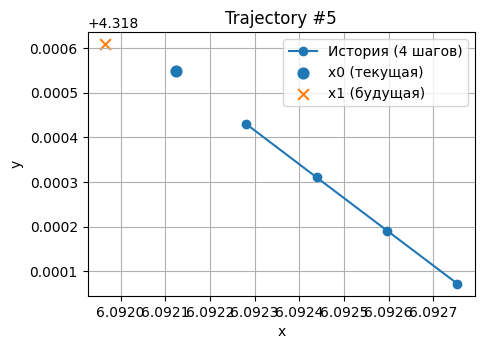

In [29]:
plot_trajectory(x0_value, x1_value, x0_hist, idx=5)

In [ ]:
import torch
import matplotlib.pyplot as plt
from typing import Optional

def plot_trajectories_grid(x0_value: torch.Tensor,
                           x1_value: torch.Tensor,
                           x0_hist: torch.Tensor,
                           rows: int = 5,
                           cols: int = 5,
                           seed: Optional[int] = 0xDEADBEEF,
                           min_span: float = 0.5,       # минимальный размер окна по оси (метры)
                           pad_ratio: float = 0.15,     # дополнительный паддинг (15%)
                           shared_limits: bool = False  # сделать одинаковые лимиты для всех сабплотов
                           ):
    """
    Рисует сетку траекторий с квадратными осями и контролем масштаба.

    - min_span: гарантирует, что даже при почти нулевом движении окно не станет «узким».
    - pad_ratio: доля от span, добавляемая как поля по краям.
    - shared_limits: если True — считаем единые лимиты для всех выбранных траекторий.
    """
    assert x0_value.ndim == 2 and x0_value.size(1) == 2
    assert x1_value.ndim == 2 and x1_value.size(1) == 2
    assert x0_hist.ndim == 2 and x0_hist.size(1) % 2 == 0

    N = x0_value.size(0)
    M = x0_hist.size(1) // 2
    K = min(rows * cols, N)

    g = torch.Generator().manual_seed(seed) if seed is not None else None
    idxs = torch.randperm(N, generator=g)[:K] if g else torch.randperm(N)[:K]

    # Предрасчёт общих лимитов (если нужно)
    if shared_limits:
        all_pts = []
        for idx in idxs.tolist():
            hist = x0_hist[idx].reshape(M, 2)
            x0 = x0_value[idx]
            x1 = x1_value[idx]
            pts = torch.vstack([hist, x0.unsqueeze(0), x1.unsqueeze(0)])
            all_pts.append(pts)
        all_pts = torch.vstack(all_pts)
        x_min, y_min = all_pts.min(dim=0).values.tolist()
        x_max, y_max = all_pts.max(dim=0).values.tolist()
        span = max(x_max - x_min, y_max - y_min, min_span)
        cx = (x_min + x_max) / 2.0
        cy = (y_min + y_max) / 2.0
        span *= (1.0 + pad_ratio)
        global_xlim = (cx - span/2, cx + span/2)
        global_ylim = (cy - span/2, cy + span/2)
    else:
        global_xlim = global_ylim = None

    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    axes = axes.flatten()

    for ax, idx in zip(axes, idxs.tolist()):
        hist = x0_hist[idx].reshape(M, 2)
        x0 = x0_value[idx]
        x1 = x1_value[idx]

        if M > 0:
            ax.plot(hist[:,0].cpu(), hist[:,1].cpu(), marker='o', linestyle='-')
        ax.scatter(x0[0].item(), x0[1].item(), s=30, label='x0')
        ax.scatter(x1[0].item(), x1[1].item(), s=30, marker='x', label='x1')

        # Квадратные оси с контролем диапазона
        ax.set_aspect('equal', adjustable='box')
        ax.set_title(f"id={idx}", fontsize=9)
        ax.grid(True)
        ax.set_xlabel("x", fontsize=8)
        ax.set_ylabel("y", fontsize=8)

        if global_xlim is not None:
            ax.set_xlim(*global_xlim)
            ax.set_ylim(*global_ylim)
        else:
            pts = torch.vstack([hist, x0.unsqueeze(0), x1.unsqueeze(0)])
            xmin, ymin = pts.min(dim=0).values.tolist()
            xmax, ymax = pts.max(dim=0).values.tolist()
            span = max(xmax - xmin, ymax - ymin, min_span)
            span *= (1.0 + pad_ratio)
            cx = (xmin + xmax) / 2.0
            cy = (ymin + ymax) / 2.0
            ax.set_xlim(cx - span/2, cx + span/2)
            ax.set_ylim(cy - span/2, cy + span/2)

    # удаляем лишние оси, если K < rows*cols
    for j in range(K, rows*cols):
        fig.delaxes(axes[j])

    fig.suptitle(f"{rows}×{cols} random trajectories", fontsize=14)
    fig.tight_layout()
    plt.show()


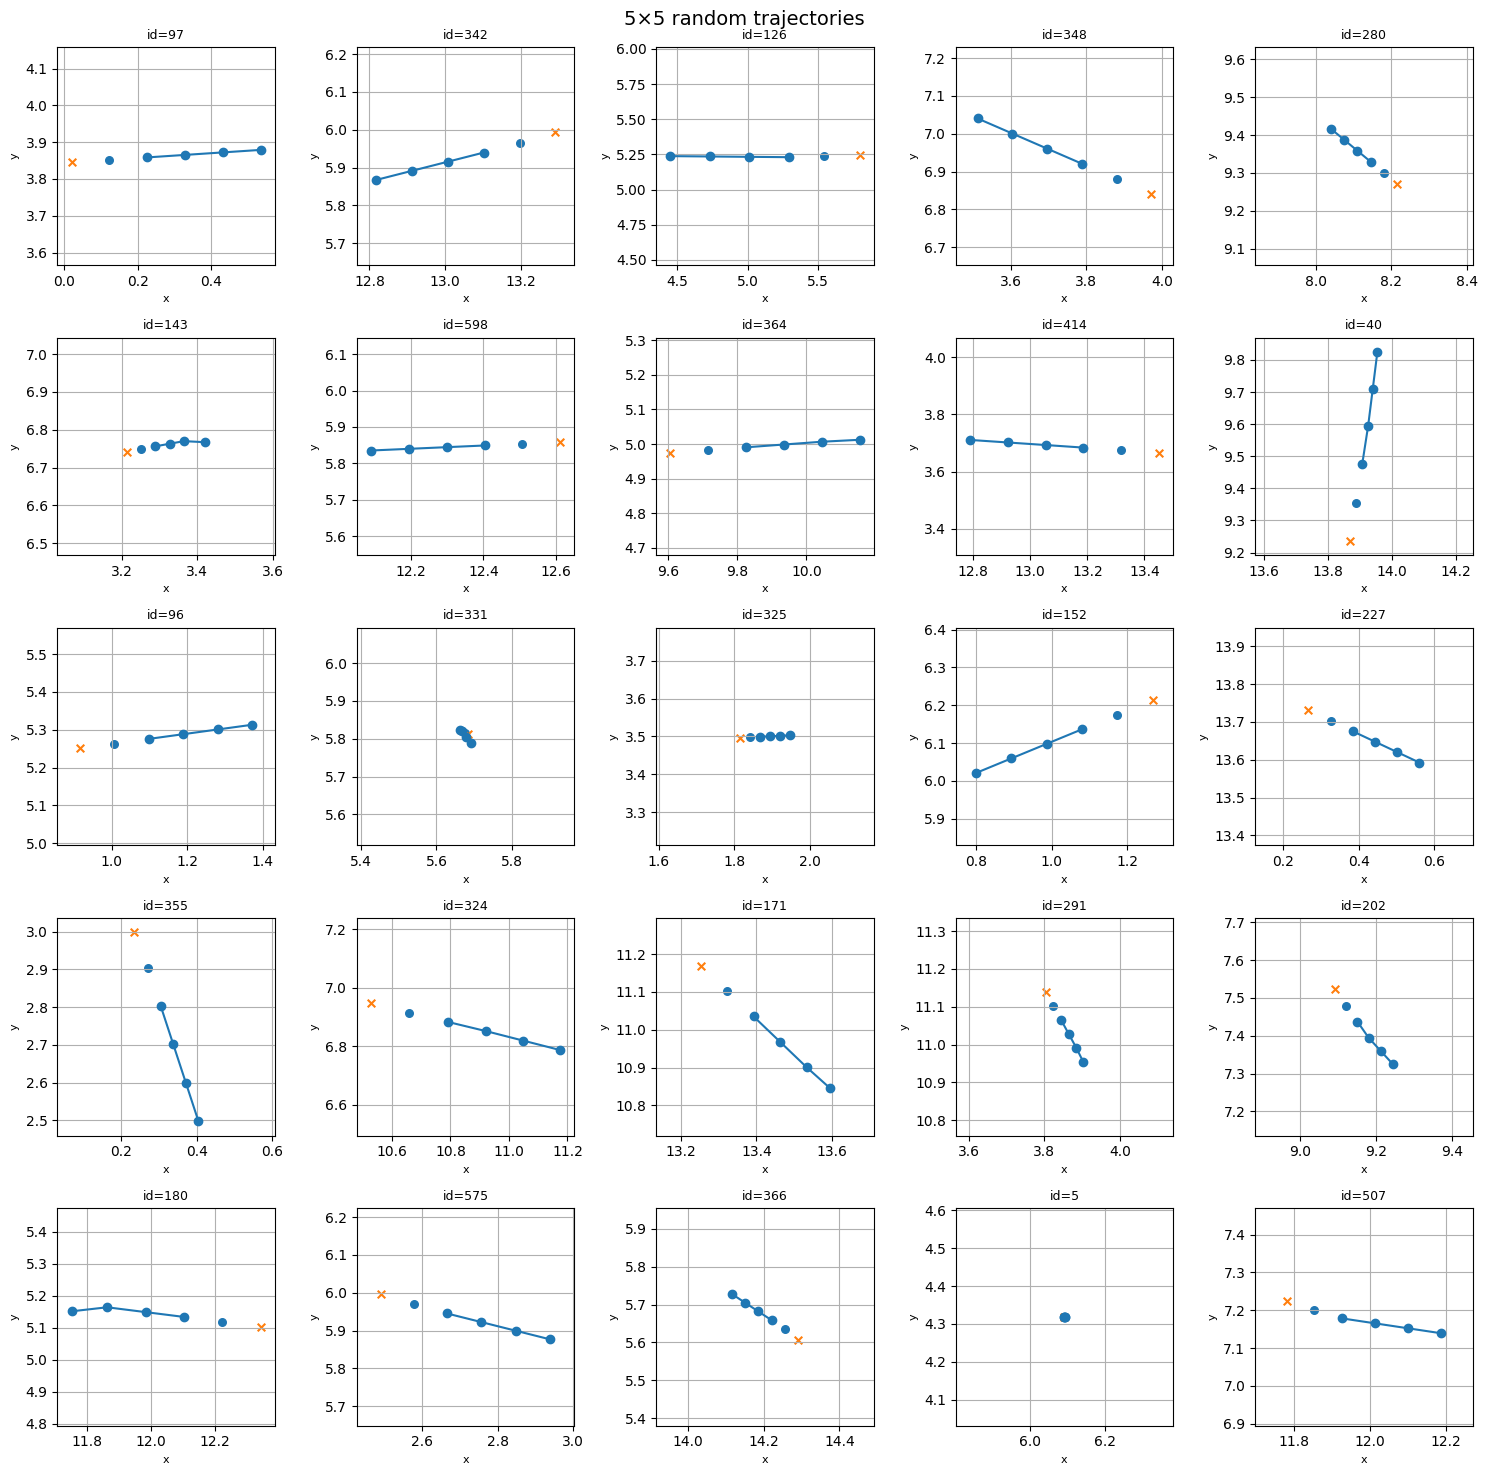

In [30]:
plot_trajectories_grid(x0_value, x1_value, x0_hist, rows=5, cols=5,
                       min_span=0.5, pad_ratio=0.15, shared_limits=False)

In [ ]:
import torch
import pytorch_lightning as pl
from src.models.tfm_mlp import Noise_MLP_Cond_Memory_Module

# Загружаем модель из чекпоинта
checkpoint_path = "/home/denis_fatykhov/Projects/sk_msd_trajectoryFM/outputs/2025-10-18/02-35-51/checkpoints/best_model.ckpt"

model = Noise_MLP_Cond_Memory_Module.load_from_checkpoint(
    checkpoint_path,
    map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

model.eval()
model.freeze()

In [ ]:
def predict_trajectories_batch(model, x0_value, x0_hist, x1_value, t0, t1, num_steps=10):
    """
    Предсказывает траектории для батча данных
    
    Args:
        model: обученная модель Noise_MLP_Cond_Memory_Module
        x0_value: (N, 2) - начальные точки
        x0_hist: (N, 2*M) - история траекторий
        x1_value: (N, 2) - целевые точки  
        t0: (N,) - начальные времена
        t1: (N,) - конечные времена
        num_steps: количество шагов для предсказания
    
    Returns:
        pred_trajectories: (N, num_steps+1, 2) - предсказанные траектории
        noise_trajectories: (N, num_steps+1, 2) - предсказания шума
    """
    from torchdyn.core import NeuralODE
    from src.models.components.grad_util import torch_wrapper_tv
    
    device = next(model.parameters()).device
    
    # Создаем ODE солверы
    node = NeuralODE(
        torch_wrapper_tv(model.flow_model), 
        solver="dopri5", 
        sensitivity="adjoint", 
        atol=1e-4, 
        rtol=1e-4
    )
    node_noise = NeuralODE(
        torch_wrapper_tv(model.noise_model), 
        solver="dopri5", 
        sensitivity="adjoint", 
        atol=1e-4, 
        rtol=1e-4
    )
    
    N = x0_value.shape[0]
    M = model.memory
    dim = model.dim
    
    pred_trajectories = []
    noise_trajectories = []
    
    with torch.no_grad():
        for i in range(N):
            # Подготавливаем данные для i-й траектории
            x0_i = x0_value[i:i+1]  # (1, 2)
            x1_i = x1_value[i:i+1]  # (1, 2)
            hist_i = x0_hist[i]     # (2*M,)
            t0_i = t0[i].item()
            t1_i = t1[i].item()
            
            # Создаем временной интервал
            time_span = torch.linspace(t0_i, t1_i, num_steps + 1).to(device)
            
            # Подготавливаем вход для модели
            # Нужно создать x0_classes в правильном формате
            # Предполагаем, что у нас нет дополнительных условий (treatment_cond = 0)
            if model.treatment_cond > 0:
                # Если есть условия, создаем нулевые
                x0_classes = torch.zeros(1, model.treatment_cond + M * dim).to(device)
            else:
                # Только история
                x0_classes = hist_i.unsqueeze(0).to(device)  # (1, 2*M)
            
            # Создаем входной тензор
            testpt = torch.cat([x0_i, x0_classes], dim=1)
            
            # Предсказываем траекторию
            traj = node.trajectory(testpt, t_span=time_span)
            noise_traj = node_noise.trajectory(testpt, t_span=time_span)
            
            # Извлекаем только координаты (первые dim измерений)
            pred_traj = traj[:, :, :dim]  # (num_steps+1, 1, 2)
            noise_traj = noise_traj[:, :, :dim]  # (num_steps+1, 1, 2)
            
            pred_trajectories.append(pred_traj.squeeze(1))  # (num_steps+1, 2)
            noise_trajectories.append(noise_traj.squeeze(1))  # (num_steps+1, 2)
    
    return torch.stack(pred_trajectories), torch.stack(noise_trajectories)

def plot_trajectories_with_predictions(x0_value, x1_value, x0_hist, pred_trajectories, 
                                     rows=5, cols=5, seed=0xDEADBEEF, 
                                     min_span=0.5, pad_ratio=0.15, shared_limits=False):
    """
    Рисует траектории с предсказаниями модели
    """
    import matplotlib.pyplot as plt
    
    assert x0_value.ndim == 2 and x0_value.size(1) == 2
    assert x1_value.ndim == 2 and x1_value.size(1) == 2
    assert x0_hist.ndim == 2 and x0_hist.size(1) % 2 == 0
    assert pred_trajectories.ndim == 3 and pred_trajectories.size(2) == 2

    N = x0_value.size(0)
    M = x0_hist.size(1) // 2
    K = min(rows * cols, N)

    g = torch.Generator().manual_seed(seed) if seed is not None else None
    idxs = torch.randperm(N, generator=g)[:K] if g else torch.randperm(N)[:K]

    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    axes = axes.flatten()

    for ax, idx in zip(axes, idxs.tolist()):
        hist = x0_hist[idx].reshape(M, 2)
        x0 = x0_value[idx]
        x1 = x1_value[idx]
        pred_traj = pred_trajectories[idx]  # (num_steps+1, 2)

        # Рисуем историю
        if M > 0:
            ax.plot(hist[:,0].cpu(), hist[:,1].cpu(), 'o-', color='blue', alpha=0.7, label='History')
        
        # Рисуем начальную и конечную точки
        ax.scatter(x0[0].item(), x0[1].item(), s=50, color='green', label='x0', zorder=5)
        ax.scatter(x1[0].item(), x1[1].item(), s=50, color='red', marker='x', label='x1', zorder=5)
        
        # Рисуем предсказанную траекторию
        ax.plot(pred_traj[:,0].cpu(), pred_traj[:,1].cpu(), '--', color='orange', linewidth=2, label='Prediction')

        # Настройки графика
        ax.set_aspect('equal', adjustable='box')
        ax.set_title(f"id={idx}", fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.set_xlabel("x", fontsize=8)
        ax.set_ylabel("y", fontsize=8)
        
        if idx == 0:  # Легенда только на первом графике
            ax.legend(fontsize=8)

        # Автоматическое масштабирование
        all_pts = torch.cat([hist, x0.unsqueeze(0), x1.unsqueeze(0), pred_traj])
        xmin, ymin = all_pts.min(dim=0).values.tolist()
        xmax, ymax = all_pts.max(dim=0).values.tolist()
        span = max(xmax - xmin, ymax - ymin, min_span)
        span *= (1.0 + pad_ratio)
        cx = (xmin + xmax) / 2.0
        cy = (ymin + ymax) / 2.0
        ax.set_xlim(cx - span/2, cx + span/2)
        ax.set_ylim(cy - span/2, cy + span/2)

    # Удаляем лишние оси
    for j in range(K, rows*cols):
        fig.delaxes(axes[j])

    fig.suptitle(f"{rows}×{cols} trajectories with predictions", fontsize=14)
    fig.tight_layout()
    plt.show()

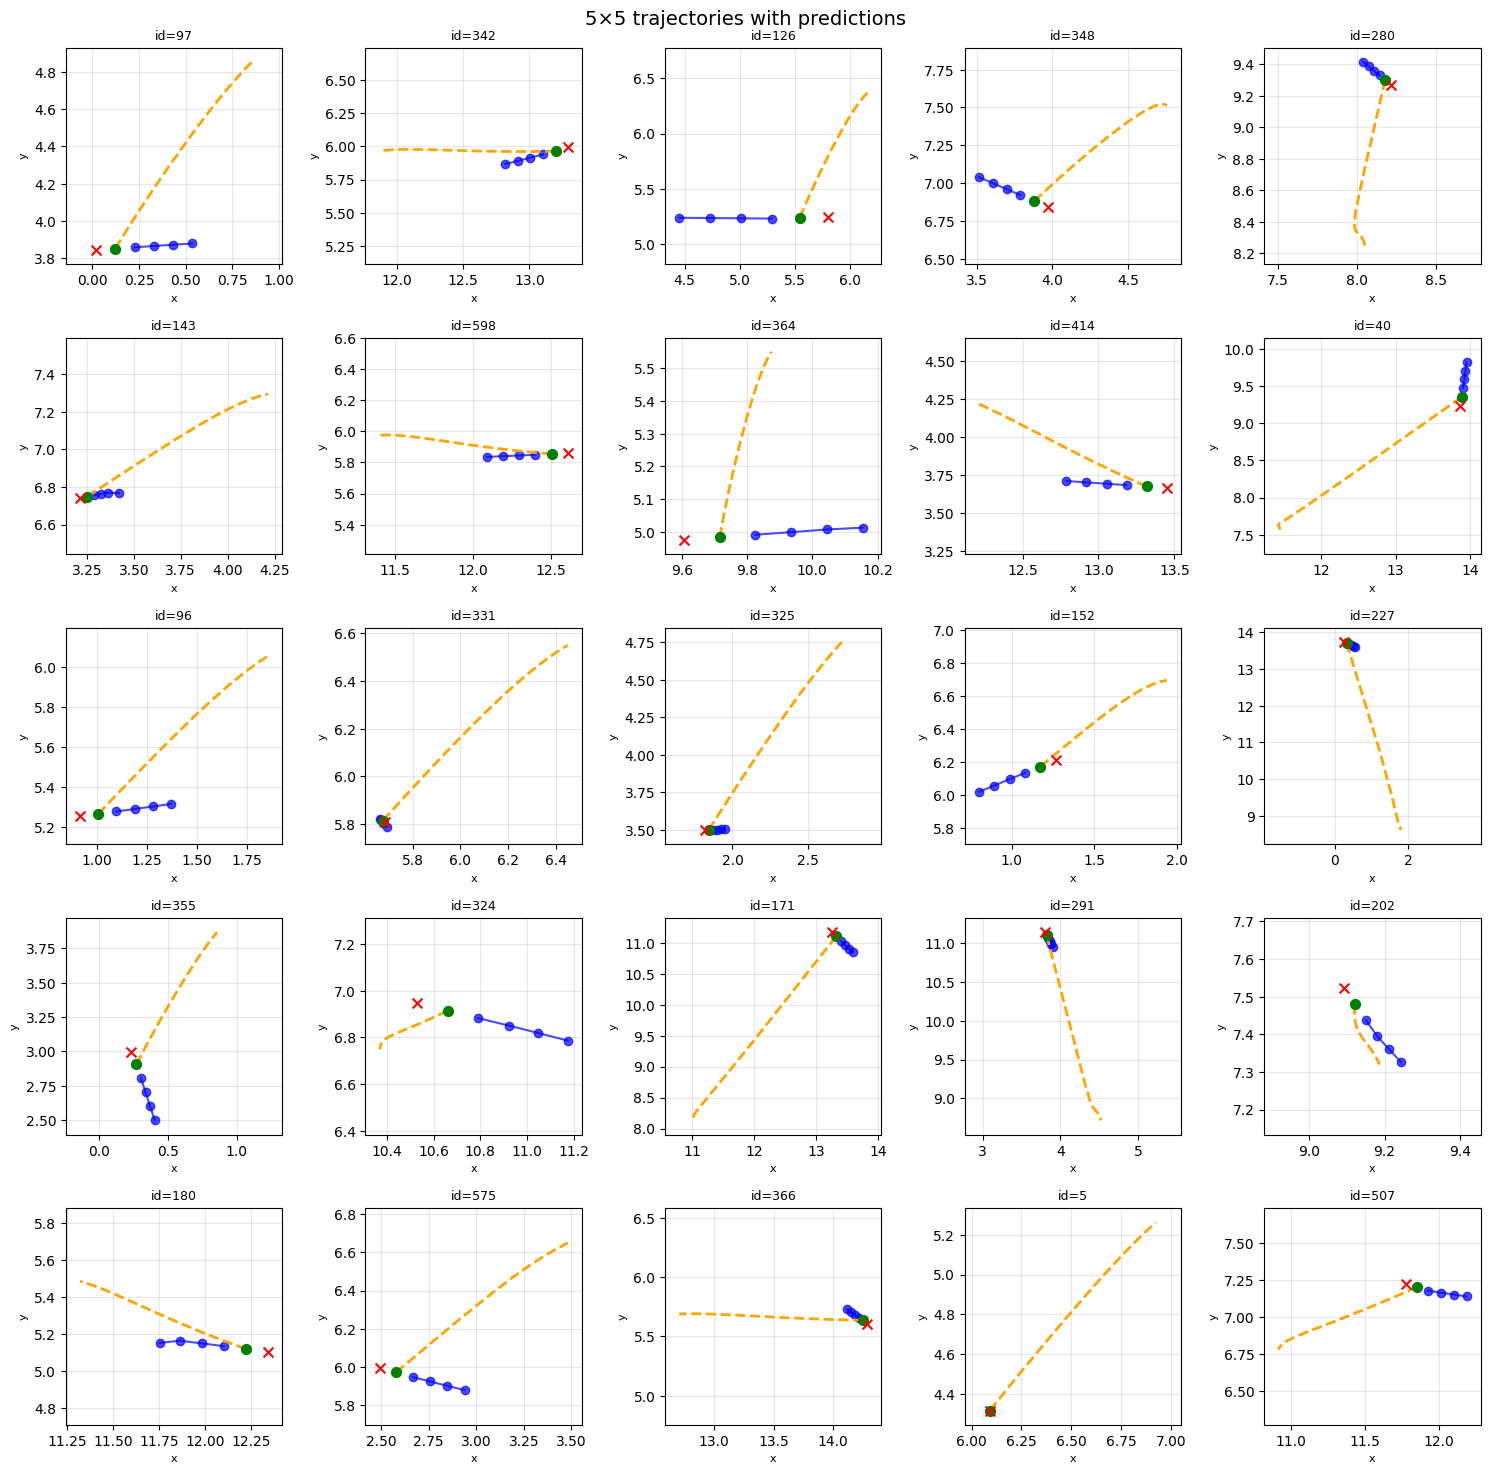

In [31]:
# Получаем предсказания для вашего батча
pred_trajectories, noise_trajectories = predict_trajectories_batch(
    model, x0_value, x0_hist, x1_value, t0, t1, num_steps=10
)

# Визуализируем результаты
plot_trajectories_with_predictions(
    x0_value, x1_value, x0_hist, pred_trajectories, 
    rows=5, cols=5, min_span=0.5, pad_ratio=0.15
)